Lambda School Data Science

*Unit 2, Sprint 2, Module 2*

---

In [30]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/main/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = (r'../data/waterpumps/')

# Module Project: Random Forests

This week, the module projects will focus on creating and improving a model for the Tanazania Water Pump datset. Your goal is to create a model to predict whether a water pump is functional, non-functional, or needs repair.

Dataset source: [DrivenData.org](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/).

## Directions

The tasks for this project are as follows:

- **Task 1:** Sign up for a [Kaggle](https://www.kaggle.com/) account.
- **Task 2:** Use `wrangle` function to import training and test data.
- **Task 3:** Split training data into feature matrix `X` and target vector `y`.
- **Task 4:** Split feature matrix `X` and target vector `y` into training and test sets.
- **Task 5:** Establish the baseline accuracy score for your dataset.
- **Task 6:** Build and train `model_dt`.
- **Task 7:** Calculate the training and validation accuracy score for your model.
- **Task 8:** Adjust model's `max_depth` to reduce overfitting.
- **Task 9 `stretch goal`:** Create a horizontal bar chart showing the 10 most important features for your model.

You should limit yourself to the following libraries for this project:

- `category_encoders`
- `matplotlib`
- `pandas`
- `pandas-profiling`
- `sklearn`

# I. Wrangle Data

In [31]:
def wrangle(fm_path, tv_path=None):
    if tv_path:
        df = pd.merge(pd.read_csv(fm_path, 
                                  na_values=[0, -2.000000e-08]),
                      pd.read_csv(tv_path)).set_index('id')
    else:
        df = pd.read_csv(fm_path, 
                         na_values=[0, -2.000000e-08],
                         index_col='id')

    # Drop constant columns
    df.drop(columns=['recorded_by'], inplace=True)

    # Drop HCCCs
    cutoff = 100
    drop_cols = [col for col in df.select_dtypes('object').columns
                 if df[col].nunique() > cutoff]
    df.drop(columns=drop_cols, inplace=True)

    # Drop duplicate columns
    dupe_cols = [col for col in df.head(15).T.duplicated().index
                 if df.head(15).T.duplicated()[col]]
    df.drop(columns=dupe_cols, inplace=True)             

    return df

**Task 1:** Sign up for a [Kaggle](https://www.kaggle.com/) account. Choose a username that's based on your real name. Like GitHub, Kaggle is part of your public profile as a data scientist.

**Task 2:** Modify the `wrangle` function to engineer a `'pump_age'` feature. Then use the function to read `train_features.csv` and `train_labels.csv` into the DataFrame `df`, and `test_features.csv` into the DataFrame `X_test`.

In [32]:
import pandas as pd

In [33]:
df = wrangle(DATA_PATH+r'train_features.csv',DATA_PATH+r'train_labels.csv')

In [34]:
df.shape

(47519, 28)

In [35]:
train = df

In [36]:
X_test = wrangle(DATA_PATH+r'test_features.csv')

In [37]:
X_test.shape

(11880, 28)

In [38]:
set(df.columns) - set(X_test.columns)

{'status_group'}

# II. Split Data

**Task 3:** Split your DataFrame `df` into a feature matrix `X` and the target vector `y`. You want to predict `'status_group'`.

In [39]:
target = 'status_group'
y = train[target]
X = train.drop(columns = target)

**Task 4:** Using a randomized split, divide `X` and `y` into a training set (`X_train`, `y_train`) and a validation set (`X_val`, `y_val`).

In [40]:
from sklearn.model_selection import train_test_split 

In [41]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.20, random_state = 0)

# III. Establish Baseline

**Task 5:** Since this is a **classification** problem, you should establish a baseline accuracy score. Figure out what is the majority class in `y_train` and what percentage of your training observations it represents.

In [42]:
y_train.value_counts(normalize=True)

#y_pred = [majority_class] * len(y_train)

functional                 0.542944
non functional             0.383559
functional needs repair    0.073497
Name: status_group, dtype: float64

In [43]:
majority_class=y_train.mode()[0]
y_pred = [majority_class] * len(y_train)

In [44]:
len(y_pred)

38015

In [45]:
from sklearn.metrics import accuracy_score

In [46]:
# Method 2
baseline_acc = accuracy_score(y_train, y_pred)
print('Baseline Accuracy Score:', baseline_acc)
# Method 1
print('Baseline Accurary Score:', y_train.value_counts(normalize = True).max()*100)

Baseline Accuracy Score: 0.542943574904643
Baseline Accurary Score: 54.29435749046429


# IV. Build Model

**Task 6:** Build a `Pipeline` named `model_rf`, and fit it to your training data. Your `Pipeline` should include:

- an `OrdinalEncoder` transformer for categorical features.
- a `SimpleImputer` transformer fot missing values.
- a `RandomForestClassifier` predictor.

**Note:** Don't forget to set the `random_state` parameter for your `RandomForestClassifier`. Also, to decrease training time, set `n_jobs` to `-1`.

In [47]:
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

In [48]:
## Requires Scaler
# model_lr = make_pipeline(
#     OrdinalEncoder(), 
#     SimpleImputer(), 
#     StandardScaler(), 
#     LogisticRegression(max_iter = 200)
# )

# model_lr.fit(X_train, y_train)

In [49]:
## Requires DecisionTreeClassifier
# model_dt = make_pipeline(
#     OrdinalEncoder(), 
#     SimpleImputer(), 
#     DecisionTreeClassifier()
# )

# model_dt.fit(X_train, y_train)

In [50]:
model_rf = make_pipeline(
      OrdinalEncoder(),
      SimpleImputer(strategy= 'mean'),
      RandomForestClassifier(n_jobs=-1, max_depth = 20, 
      n_estimators = 285, random_state=0))

model_rf.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity', 'source',
                                      'source_type', 'source_class',
                                      'waterpoint_type'],
                                mapping=[{'col': 'basin',
                                          'data_typ...
                                          'mapping': groundwater    1
surface        2
unknown        3
NaN           -2
dtype: int64},
                                         {'col': 'waterpoint_type',
                          

# V. Check Metrics

**Task 7:** Calculate the training and validation accuracy scores for `model_rf`.

In [51]:
## Method 2
# training_acc = accuracy_score(y_train, model_rf.predict(X_train))
# val_acc = accuracy_score(y_val, model_rf.predict(X_val))
# Training Accuracy Score: 0.9543761442791304
# Validation Accuracy Score: 0.8088383838383838

## Method 1
# training_acc = model_rf.score(X_train, y_train)
# val_acc = model_rf.score(X_val, y_val)
# Training Accuracy Score: 0.9543761442791304
# Validation Accuracy Score: 0.8088383838383838

# print('Training Accuracy Score:', training_acc)
# print('Validation Accuracy Score:', val_acc)

#Random Forest Accuracy
print('Random Forest Accuracy')
print('Training Accuracy:', model_rf.score(X_train, y_train))
print('Validation Accuracy:', model_rf.score(X_val, y_val))

Random Forest Accuracy
Training Accuracy: 0.9534920426147573
Validation Accuracy: 0.7999789562289562


# VI. Tune Model

**Task 8:** Tune `n_estimators` and `max_depth` hyperparameters for your `RandomForestClassifier` to get the best validation accuracy score for `model_rf`. 

In [54]:
# Use this cell to experiment and then change 
# your model hyperparameters in Task 6
max_depths = range(2,40, 4)

list(max_depths)

[2, 6, 10, 14, 18, 22, 26, 30, 34, 38]

In [55]:
val_acc = []
train_acc = []

for depth in max_depths:
  model_rf = make_pipeline(
      OrdinalEncoder(), 
      SimpleImputer(), 
      RandomForestClassifier(max_depth = depth))

  model_rf.fit(X_train, y_train)
  train_acc.append(model_rf.score(X_train, y_train))
  val_acc.append(model_rf.score(X_val, y_val))

In [56]:
import matplotlib.pyplot as plt

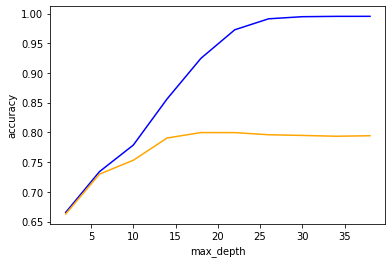

In [57]:
#Validation curves

plt.plot(max_depths, train_acc, color = 'blue', label = 'training')
plt.plot(max_depths, val_acc, color = 'orange', label = 'validation')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.show()

In [58]:
#Retrain RF with optimal Hyperparameters

model_rf = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(max_depth = 20)
)

model_rf.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity', 'source',
                                      'source_type', 'source_class',
                                      'waterpoint_type'],
                                mapping=[{'col': 'basin',
                                          'data_typ...
                                         {'col': 'source_class',
                                          'data_type': dtype('O'),
                                          'mapping': groundwater    1
surface        2
unknown    

# VII. Communicate Results

**Task 9:** Generate a list of predictions for `X_test`. The list should be named `y_pred`.

<AxesSubplot:>

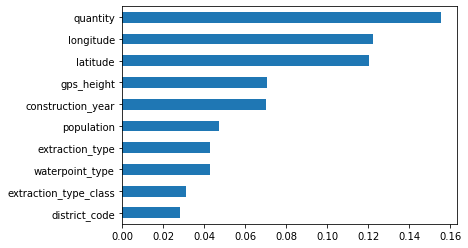

In [59]:
features = model_rf.named_steps['ordinalencoder'].get_feature_names()
gini = model_rf.named_steps['randomforestclassifier'].feature_importances_

pd.Series(data = gini, index = features).sort_values(key = abs).tail(10).plot(kind = 'barh')


In [60]:
#y_pred = []

assert len(y_pred) == len(X_test), f'Your list of predictions should have {len(X_test)} items in it. '

AssertionError: Your list of predictions should have 11880 items in it. 

**Task 11 `stretch goal`:** Create a DataFrame `submission` whose index is the same as `X_test` and that has one column `'status_group'` with your predictions. Next, save this DataFrame as a CSV file and upload your submissions to our competition site. 

**Note:** Check the `sample_submission.csv` file on the competition website to make sure your submissions follows the same formatting. 

In [ ]:
#Change working directory
#os.chdir(outputs)

predictions = pd.DataFrame(data=model_rf.predict(X_test), index=X_test.index)

predictions.columns = ['status_group']

predictions.insert(0, 'id', predictions.index)

predictions = predictions.reset_index(drop=True)


In [ ]:
len(predictions)


In [ ]:
# generate CSV
predictions.to_csv('sample_submission_greg.somers_rf.csv', index=False)

In [ ]:
submission = ...